In [1]:
import os
import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

import pandas as pd
pd.core.common.is_list_like = pd.api.types.is_list_like
import empyrical as emp
import tushare as ts
import time
import random
# from concurrent.futures import ProcessPoolExecutor

from common.log import *
from common.config import Config
from spider.spider_nasdaq import Spider_nasdaq

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

from pandas_highcharts.core import serialize
from pandas_highcharts.display import display_charts

CONF = Config().data[0]
MONGODB = CONF['MONGODB']
NASDAQ = CONF['NASDAQ']
CRYPTOCURRENCY = CONF['CRYPTOCURRENCY']
NASDAQ100 = CONF['NASDAQ100']
# NASDAQ100 = ['NDX', 'TSLA', 'NVDA', 'AMZN', 'GOOGL', 'GOOG', 'BIDU', 'FB', 'JD']
HS300 = list(ts.get_hs300s()['code']) + ['399300']
print(HS300)

pd

['600000', '600008', '600009', '600010', '600011', '600015', '600016', '600018', '600019', '600023', '600025', '600028', '600029', '600030', '600031', '600036', '600038', '600048', '600050', '600061', '600066', '600068', '600085', '600089', '600100', '600104', '600109', '600111', '600115', '600118', '600153', '600157', '600170', '600176', '600177', '600188', '600196', '600208', '600219', '600221', '600233', '600271', '600276', '600297', '600309', '600332', '600339', '600340', '600346', '600352', '600362', '600369', '600372', '600373', '600376', '600383', '600390', '600398', '600406', '600415', '600436', '600438', '600482', '600487', '600489', '600498', '600516', '600518', '600519', '600522', '600535', '600547', '600549', '600570', '600583', '600585', '600588', '600606', '600637', '600660', '600663', '600674', '600682', '600688', '600690', '600703', '600704', '600705', '600739', '600741', '600795', '600804', '600809', '600816', '600820', '600837', '600867', '600886', '600887', '600893',

<module 'pandas' from 'd:\\python3\\lib\\site-packages\\pandas\\__init__.py'>

In [2]:
%%time

# for symbol in HS300[:]:
for symbol in ['399300']:
    df = ts.get_k_data(code=symbol, index=True, start='2008-01-01', end='2018-05-01')
#     df = ts.get_k_data(code=symbol, ktype='D', autype='qfq', index=False, start='2008-01-01', end='2018-05-01')
    datafile = '../database/market/%s.csv' % symbol
    df.to_csv(datafile, index=False, encoding='utf-8')
    print(datafile)
    time.sleep(1)

../database/market/399300.csv
Wall time: 1.68 s


In [3]:
%%time

### 时间设置
start_date = '2008-01-02'
# start_date = '2010-01-01'
# start_date = '2015-01-01'
# start_date = '2017-01-03'
start_date = '2018-01-01'
end_date = '2018-04-27'

TURTLE_POS = 20
### Turtle System One - Short
TURTLE_SHORT_BUY_N = 20
TURTLE_SHORT_SELL_N = 20
### Turtle System Two - Long
TURTLE_LONG_BUY_N = 60
TURTLE_LONG_SELL_N = 60

### 业务设置
IS_HAPPYMONEY = False
IS_TAX = False
IS_SLIPPAGE = False
IS_RANDOM_BUY = True
START_MONEY = 100000
HAPPY_MONEY = 0
PROPERTY = START_MONEY
CASH = START_MONEY


Wall time: 0 ns


In [4]:
%%time

stock_df_dict = {}

for symbol in HS300[:]:
    stock_data_file = '../database/market/%s.csv' % symbol
    stock_df = pd.read_csv(stock_data_file)

    # 筛选字段
    stock_df = stock_df.loc[:, ['date', 'open', 'close']]
#     stock_df = stock_df.loc[:, ['date', 'close']]

    # 去掉Nasdaq行情首行的当天行情
    if symbol in NASDAQ:
        stock_df = stock_df.drop([0])

    # 抛弃空值异常值
    stock_df.dropna(axis=0, how='any', inplace=True)

    # 格式化日期
    # 1.48 s ± 45.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
#     stock_df['date'] = stock_df['date'].apply(lambda x: pd.Period(x, freq='D'))

    # 445 ms ± 17.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
    stock_df = stock_df.assign(date=pd.to_datetime(stock_df['date']))  # need .index.to_period('D')

    # 476 ms ± 46.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
#     stock_df['date'] = pd.to_datetime(stock_df['date'])  # need .index.to_period('D')
    
    # 转换字段格式
#     stock_df = stock_df.astype(dtype={'volume': 'float64'})

    # 用日期作索引，日期升序排序
    # 95.1 µs ± 1.58 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
#     stock_df = stock_df[::-1]
    
    # 407 µs ± 5.07 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
#     %timeit stock_df.set_index(['date'], inplace=False)

    # Wall time: 500 µs
    stock_df.set_index(['date'], inplace=True)
    
    # 305 µs ± 2.75 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
#     stock_df = stock_df.sort_index(axis=0, ascending=True)
    
    # 822 µs ± 41.3 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
    stock_df.index = stock_df.index.to_period('D')

    # 计算涨跌幅
#     stock_df['c_pct_chg'] = stock_df.close.pct_change(1)
    stock_df['o_pct_chg'] = stock_df.open.pct_change(1)
    
    # Turtle指标
#     stock_df['TR1'] = abs(stock_df['high'] - stock_df['low'])
#     stock_df['TR2'] = abs(stock_df['high'] - stock_df['close'].shift())
#     stock_df['TR3'] = abs(stock_df['low'] - stock_df['close'].shift())
#     stock_df['TR'] = stock_df[['TR1', 'TR2', 'TR3']].max(axis=1)
#     stock_df['N'] = stock_df['TR'].rolling(20).mean()
#     stock_df['UNIT'] = (0.01 * START_MONEY) / (stock_df['N'])
    stock_df['ROLLING_%d_MAX' % TURTLE_SHORT_BUY_N] = stock_df['open'].rolling(TURTLE_SHORT_BUY_N).max()
    stock_df['ROLLING_%d_MIN' % TURTLE_SHORT_SELL_N] = stock_df['open'].rolling(TURTLE_SHORT_SELL_N).min()
    stock_df['ROLLING_%d_MAX' % TURTLE_LONG_BUY_N] = stock_df['open'].rolling(TURTLE_LONG_BUY_N).max()
    stock_df['ROLLING_%d_MIN' % TURTLE_LONG_SELL_N] = stock_df['open'].rolling(TURTLE_LONG_SELL_N).min()
#     stock_df['MA%d' % TURTLE_BUY_N] = stock_df['open'].rolling(TURTLE_BUY_N).mean()
#     stock_df['MA%d' % TURTLE_SELL_N] = stock_df['open'].rolling(TURTLE_SELL_N).mean()
#     stock_df['EWMA'] = stock_df['open'].ewm(alpha=0.1, adjust=False).mean()
#     stock_df['MA360'] = stock_df['open'].rolling(360).mean()
    stock_df['MA180'] = stock_df['open'].rolling(180).mean()
    stock_df['MA60'] = stock_df['open'].rolling(60).mean()
    stock_df['MA30'] = stock_df['open'].rolling(30).mean()
    
#     stock_df['ops'] = ''
#     stock_df['profit'] = 0
    
    # 减少数据
    # stock_df = stock_df['2016-01-01':]
    stock_df.dropna(how='any', inplace=True)
#     stock_df.drop(columns=['volume', 'TR1', 'TR2', 'TR3'], inplace=True)
    
    stock_df_dict[symbol] = stock_df
    
#     print(stock_df.head(10))
#     print(stock_df.dtypes)
#     print(stock_df.index[0])
#     print(type(stock_df.index[0]))

Wall time: 8.08 s


In [5]:
stock_df_dict['399300'].head(10)
stock_df_dict['399300'].tail(10)

,open,close,o_pct_chg,ROLLING_20_MAX,ROLLING_20_MIN,ROLLING_60_MAX,ROLLING_60_MIN,MA180,MA60,MA30
date,,,,,,,,,,
2008-09-23,2141.60,2123.48,-0.038939,2372.64,1876.96,2987.06,1876.96,3602.807111,2547.598000,2262.171667
2008-09-24,2072.65,2138.85,-0.032196,2372.64,1876.96,2987.06,1876.96,3584.600944,2535.488833,2250.214000
2008-09-25,2143.73,2223.53,0.034294,2372.64,1876.96,2987.06,1876.96,3566.615278,2526.173833,2240.755000
2008-09-26,2234.46,2243.66,0.042323,2372.64,1876.96,2987.06,1876.96,3548.858778,2519.173500,2234.237667
2008-10-06,2206.56,2128.70,-0.012486,2372.64,1876.96,2987.06,1876.96,3530.670556,2510.096000,2226.443333
2008-10-07,2043.92,2102.45,-0.073707,2292.69,1876.96,2987.06,1876.96,3511.048167,2498.367833,2212.863667
2008-10-08,2041.99,2022.88,-0.000944,2279.60,1876.96,2987.06,1876.96,3491.797444,2484.058167,2204.746333
2008-10-09,2059.58,1995.30,0.008614,2238.65,1876.96,2987.06,1876.96,3471.952611,2469.601167,2195.652667
2008-10-10,1913.27,1906.96,-0.071039,2234.46,1876.96,2987.06,1876.96,3450.978778,2451.972667,2176.286333


,open,close,o_pct_chg,ROLLING_20_MAX,ROLLING_20_MIN,ROLLING_60_MAX,ROLLING_60_MIN,MA180,MA60,MA30
date,,,,,,,,,,
2018-04-16,3862.47,3808.86,-0.014862,4097.02,3850.15,4389.45,3846.27,3970.873111,4073.852167,3976.503000
2018-04-17,3812.87,3748.64,-0.012842,4097.02,3812.87,4389.45,3812.87,3971.360500,4067.314333,3969.767000
2018-04-18,3785.31,3766.28,-0.007228,4097.02,3785.31,4389.45,3785.31,3971.622333,4059.905500,3961.888667
2018-04-19,3774.78,3811.84,-0.002782,4097.02,3774.78,4389.45,3774.78,3971.902333,4052.558167,3953.215000
2018-04-20,3801.21,3760.85,0.007002,4062.07,3774.78,4389.45,3774.78,3972.227722,4044.882000,3944.472000
2018-04-23,3754.69,3766.33,-0.012238,3935.67,3754.69,4389.45,3754.69,3972.404444,4036.470500,3934.996667
2018-04-24,3769.88,3843.49,0.004046,3935.67,3754.69,4389.45,3754.69,3972.787889,4027.936167,3924.390333
2018-04-25,3824.59,3828.70,0.014512,3935.67,3754.69,4389.45,3754.69,3973.460667,4020.404667,3914.186333
2018-04-26,3823.39,3755.49,-0.000314,3935.67,3754.69,4389.45,3754.69,3974.021556,4011.679667,3904.155000


In [6]:
# %matplotlib inline

# import matplotlib
# import matplotlib.pyplot as plt
# plt.rcParams['figure.figsize'] = [30, 20]

# df = stock_df_dict['TSLA'].iloc[800:].copy()
# df.columns
# df.tail(10)
# # df[(df.open == df.rolling_60_max)]
# # df[(df.open >= df.rolling_60_max) & (df.MA30 > df.MA60)]
# # df[(df.MA30 > df.MA60)]

# # df = df.loc[:, ['open', 'ROLLING_60_MAX', 'rolling_30_min', 'MA60', 'MA30']]

# df.reset_index(drop=False, inplace=True)
# df = df.astype(dtype={'date': 'datetime64[ns]'})
# df.set_index('date', inplace=True)
# # df.index.astype()

# display_charts(df, chart_type='stock', kind='line', y=['open', 'ROLLING_60_MAX', 'ROLLING_60_MIN'], figsize=(900, 600), logy=False)

# # display_charts(df)

# # ax = df.plot(kind='line', y=['open', 'rolling_max', 'rolling_min'], label='', linewidth=1)

# # sum_buy_sig_short = 0
# # sum_buy_sig_long = 0
# # for symbol in NASDAQ100:
# #     tdf = stock_df_dict[symbol]
# #     buy_sig_short = tdf[(stock_df_dict[symbol].open == stock_df_dict[symbol]['ROLLING_%d_MAX' % TURTLE_SHORT_BUY_N])]
# #     buy_sig_long = tdf[(stock_df_dict[symbol].open == stock_df_dict[symbol]['ROLLING_%d_MAX' % TURTLE_LONG_BUY_N])]
# #     buy_sig_short_2 = buy_sig_short[buy_sig_short.MA30 >= buy_sig_short.MA180]
# #     buy_sig_long_2 = buy_sig_long[buy_sig_long.MA30 >= buy_sig_long.MA180]
# # #     print(symbol, len(tdf), len(buy_sig_short), len(buy_sig_short_2), len(buy_sig_long), len(buy_sig_long_2))
# #     sum_buy_sig_short += len(buy_sig_short_2)
# #     sum_buy_sig_long += len(buy_sig_long_2)
# # print(len(stock_df_dict['NDX']), sum_buy_sig_short, sum_buy_sig_long)

In [7]:
# algo = stock_df_dict['TSLA'].open.pct_change()
# benchmark = stock_df_dict['NDX'].open.pct_change()

# 'cum_returns', emp.cum_returns(algo)[-1]
# 'max_drawdown', emp.max_drawdown(algo), emp.max_drawdown(benchmark)
# 'annual_return', emp.annual_return(algo), emp.annual_return(benchmark)
# 'annual_volatility', emp.annual_volatility(algo, period='daily')
# 'calmar_ratio', emp.calmar_ratio(algo)
# 'sharpe_ratio', emp.sharpe_ratio(returns=algo)
# 'alpha', emp.alpha(returns=algo, factor_returns=benchmark, risk_free=0.00)
# 'beta', emp.beta(returns=algo, factor_returns=benchmark, risk_free=0.00)

# emp_df = None
# emp_df = pd.DataFrame(columns=[
#     'symbol', 'cum_returns', 'annual_return', 'annual_volatility', 'max_drawdown', 'alpha', 'beta', 'sharpe_ratio', 'calmar_ratio'
# ])

# for symbol in NASDAQ100:
#     algo = stock_df_dict[symbol].open.pct_change()
#     emp_df = emp_df.append(
#         {
#             'symbol': symbol,
#             'cum_returns': emp.cum_returns(algo)[-1],
#             'annual_return': emp.annual_return(algo),
#             'annual_volatility': emp.annual_volatility(algo, period='daily'),
#             'max_drawdown': emp.max_drawdown(algo),
#             'alpha': round(emp.alpha(returns=algo, factor_returns=benchmark, risk_free=0.00), 2),
#             'beta': round(emp.beta(returns=algo, factor_returns=benchmark, risk_free=0.00), 2),
#             'sharpe_ratio': emp.sharpe_ratio(returns=algo),
#             'calmar_ratio': emp.calmar_ratio(algo)
#         },
#         ignore_index=True,
#     )

# # emp_df
# # emp_df.sort_values('cum_returns', ascending=False)
# # emp_df.sort_values('sharpe_ratio', ascending=False)

In [8]:
%%time

show_df = None
show_df = stock_df_dict['399300'].copy()

Wall time: 501 µs


In [9]:
%%time
# %xmode

PROPERTY = START_MONEY
CASH = START_MONEY

order_df = None
order_df = pd.DataFrame(columns=[
    'buy_date', 'symbol', 'buy_count', 'buy_price', 'buy_reason', 'sell_date', 'sell_price', 'sell_reason', 'profit', 'cash', 'property'
])
count_day = 0
yesterday = None
miss_buy_short = 0
miss_buy_long = 0

for today in pd.period_range(start=start_date, end=end_date, freq='D'):
    count_day += 1
    
    if yesterday is None:
        yesterday = today
        continue

    if today not in stock_df_dict['399300'].index:
        continue

    if IS_HAPPYMONEY:        
        if PROPERTY > START_MONEY * 2:
            HAPPY_MONEY += 50000
            PROPERTY -= 50000
            CASH = PROPERTY
    
    # 买卖过程
    for symbol in HS300[:]:
#     for symbol in ['TSLA']:
        if symbol in ['ALGN', 'ROST', 'ORLY', 'ESRX', 'ULTA', 'REGN', 'MNST']:
#             continue
            pass

        if symbol == '399300':
            continue
        
        if today not in stock_df_dict[symbol].index or yesterday not in stock_df_dict[symbol].index:
            continue
            
        # TIME TEST
#         print(order_df)
#         print(order_df.columns)
        
#         %timeit (len(order_df[order_df['symbol'] == symbol]) != 0)
#         %timeit order_df[order_df['symbol'] == symbol].shape[0] != 0
#         %timeit n_order_df = order_df.values
#         %timeit len(n_order_df[n_order_df[:, 1] == symbol]) != 0
#         %timeit (len(order_df[(order_df['symbol'] == symbol) & (order_df['sell_price'] == 0)]) == 0)


#         iiidx = stock_df_dict[symbol].index.get_loc(today)
#         print(iiidx, type(iiidx))
#         %timeit stock_df_dict[symbol].loc[today]
#         %timeit n_stock_df = stock_df_dict[symbol].values
#         %timeit n_stock_df[iiidx]
        
#         %timeit (stock_df_dict[symbol].loc[today, 'open'] >= stock_df_dict[symbol].loc[today, 'rolling_max'])
#         %timeit (stock_df_dict[symbol].loc[today, 'open'] >= stock_df_dict[symbol].loc[today, 'rolling_max'])

#         %timeit int(stock_df_dict[symbol].shift(1).loc[today, 'Unit'])
#         %timeit int(CASH / stock_df_dict[symbol].loc[today, 'open'])
#         %timeit buy_count * stock_df_dict[symbol].loc[today, 'open']
#         %timeit stock_df_dict[symbol]
#         %timeit stock_df_dict[symbol].loc[today, 'open']
#         %timeit (stock_df_dict[symbol].loc[today, 'open'] > order_df[(order_df['symbol'] == symbol) & (order_df['sell_price'] == 0)].buy_price.iloc[-1] + 0.5 * stock_df_dict[symbol].shift(1).loc[today, 'N'])
        
#         n_order_df = order_df.values
#         n_stock_df = stock_df_dict[symbol].values
#         today_idx = stock_df_dict[symbol].index.get_loc(today)
#         is_has_order = (len(n_order_df[n_order_df[:, 1] == symbol]) != 0)
#         is_order_soldout = not is_has_order and (len(n_order_df[n_order_df[:, 6] == symbol]) == 0)
        
#         is_has_order = (len(order_df[order_df['symbol'] == symbol]) != 0)
#         is_order_soldout = (len(order_df[(order_df['symbol'] == symbol) & (order_df['sell_price'] == 0)]) == 0)
        
    
#         '''
#         'buy_date', 'symbol', 'buy_count', 'buy_price', 'buy_reason', 'sell_date', 'sell_price', 'sell_reason', 'profit', 'cash', 'property'
#         stock_df['ROLLING_%d_MAX' % TURTLE_SHORT_BUY_N] = stock_df['open'].rolling(TURTLE_SHORT_BUY_N).max()
#         stock_df['ROLLING_%d_MIN' % TURTLE_SHORT_SELL_N] = stock_df['open'].rolling(TURTLE_SHORT_SELL_N).min()
#         stock_df['ROLLING_%d_MAX' % TURTLE_LONG_BUY_N] = stock_df['open'].rolling(TURTLE_LONG_BUY_N).max()
#         stock_df['ROLLING_%d_MIN' % TURTLE_LONG_SELL_N] = stock_df['open'].rolling(TURTLE_LONG_SELL_N).min()
#         '''

        today_market = stock_df_dict[symbol].loc[today]
        
        # 突破下行趋势，清仓退出
        order_arr = order_df.to_records(index=False)
        if len(order_arr[(order_arr.symbol == symbol) & (order_arr.sell_price == 0)] ) != 0:
            is_sell = False
            for idx in order_df[(order_df['symbol'] == symbol) & (order_df['sell_price'] == 0)].index:
                cur_order = order_df.loc[idx]
                if cur_order.buy_reason == 'SHORT':
                    is_sell = (today_market.open <= today_market['ROLLING_%d_MIN' % TURTLE_SHORT_SELL_N])
                if cur_order.buy_reason == 'LONG':
                    is_sell = (today_market.open <= today_market['ROLLING_%d_MIN' % TURTLE_LONG_SELL_N])
                if is_sell:
                    CASH += cur_order.buy_count * today_market.open
                    order_df.loc[idx, 'sell_date'] = today
                    order_df.loc[idx, 'sell_price'] = today_market.open
                    order_df.loc[idx, 'sell_reason'] = 'EXIT'
                    order_df.loc[idx, 'profit'] = \
                        (today_market.open - cur_order.buy_price) * cur_order.buy_count
#                 print(today, '退出', stock_df_dict[symbol].loc[today, 'open'], CASH)


        # 突破上行趋势，就买一份
        order_arr = order_df.to_records(index=False)
        if today_market.MA60 >= today_market.MA180:
#         if today_market.MA30 >= today_market.MA180:
            is_buy = False
            if today_market.open >= today_market['ROLLING_%d_MAX' % TURTLE_LONG_BUY_N]:
                is_buy = True
                buy_reason = 'LONG'
            elif False and today_market.open >= today_market['ROLLING_%d_MAX' % TURTLE_SHORT_BUY_N]:
                is_buy = True
                buy_reason = 'SHORT'
            if is_buy:
                buy_count = 0
                
                if IS_SLIPPAGE:
                    buy_price = today_market.open * (1 + random.randint(0, 20) / 1000)
                else:
                    buy_price = today_market.open

                if CASH >= START_MONEY / TURTLE_POS:
                    buy_count = int((START_MONEY / TURTLE_POS) / buy_price)
                
                if IS_RANDOM_BUY:
                    if random.randint(0, 100) > 50:
                        buy_count = 0

                if buy_count > 0:
#                     buy_count = 1
                    CASH -= buy_count * buy_price
#                     print(today, '建仓', buy_count, stock_df_dict[symbol].loc[today, 'open'], CASH)
                    order_df = order_df.append(
                        {
                            'buy_date': today,
                            'symbol': symbol,
                            'buy_count': buy_count,
                            'buy_price': today_market.open,
                            'buy_reason': buy_reason,
                            'sell_date': pd.np.nan,
                            'sell_price': 0,
                            'profit': 0,
                            'cash': CASH,
                            'property': PROPERTY,
                        },
                        ignore_index=True
                    )
                else:
                    if buy_reason == 'LONG':
                        miss_buy_long += 1
                    elif buy_reason == 'SHORT':
                        miss_buy_short += 1
            
    # 每天盘点财产
    show_df.loc[today, 'CASH_TURTLE_%d_%d_%d' % (TURTLE_POS, TURTLE_LONG_BUY_N, TURTLE_LONG_SELL_N)] = CASH
    PROPERTY = CASH + \
        sum(
            [
                stock_df_dict[order_df.loc[idx, 'symbol']][:today].iloc[-1].open * order_df.loc[idx, 'buy_count'] \
                for idx in order_df.loc[order_df['sell_price']==0].index
            ]
        )
    show_df.loc[today, 'PROPERTY_TURTLE_%d_%d_%d' % (TURTLE_POS, TURTLE_LONG_BUY_N, TURTLE_LONG_SELL_N)] = PROPERTY

    yesterday = today


    
# 最后一天，清仓
order_arr = order_df.to_records(index=False)
for idx in order_df[order_df['sell_price'] == 0].index:
    cur_order = order_df.loc[idx]
    symbol = cur_order['symbol']
    today_market = stock_df_dict[symbol][:today].iloc[-1]
    CASH += cur_order.buy_count * today_market.open
    order_df.loc[idx, 'sell_date'] = today
    order_df.loc[idx, 'sell_price'] = today_market.open
    order_df.loc[idx, 'sell_reason'] = 'EXIT'
    order_df.loc[idx, 'profit'] = \
        (today_market.open - cur_order.buy_price) * cur_order.buy_count


print(CASH)
print(HAPPY_MONEY)
print(PROPERTY)

s_p = stock_df_dict['399300'][start_date:].iloc[0].open
e_p = stock_df_dict['399300'].iloc[-1].open
print('BENCHMARK', s_p, e_p, e_p / s_p)


92528.689
0
92528.689
BENCHMARK 4045.21 3771.04 0.932223543401
Wall time: 20.6 s


In [10]:
'ALL'
'start_date', start_date
'end_date', end_date
'TURTLE_POS', TURTLE_POS
'TURTLE_SHORT_BUY_N', TURTLE_SHORT_BUY_N
'TURTLE_SHORT_SELL_N', TURTLE_SHORT_SELL_N
'TURTLE_LONG_BUY_N', TURTLE_LONG_BUY_N
'TURTLE_LONG_SELL_N', TURTLE_LONG_SELL_N
'IS_HAPPYMONEY', IS_HAPPYMONEY
'IS_TAX', IS_TAX
'IS_SLIPPAGE', IS_SLIPPAGE
'IS_RANDOM_BUY', IS_RANDOM_BUY
'START_MONEY', START_MONEY

'len(order_df)', len(order_df)
sum_profit = sum(list(order_df['profit']))
'sum_profit', sum_profit
# sum_tax = sum(list(order_df_TB['tax']))
sum_tax = 0
'sum_tax', sum_tax
'win rate', len(order_df[order_df.profit > 0]) / len(order_df[order_df.profit != 0])
# 'REWARD', ((sum_profit - sum_tax) / START_MONEY + 1) ** (365 / count_day)
'len(order_df[order_df.profit != 0])', len(order_df[order_df.profit != 0])
'len(order_df[order_df.profit > 0])', len(order_df[order_df.profit > 0])
'order LONG', len(order_df[order_df.buy_reason == 'LONG'])
len(order_df[(order_df.buy_reason == 'LONG') & (order_df.profit > 0)])
sum(list(order_df[order_df.buy_reason == 'LONG']['profit']))
'order SHORT', len(order_df[order_df.buy_reason == 'SHORT'])
len(order_df[(order_df.buy_reason == 'SHORT') & (order_df.profit > 0)])
sum(list(order_df[order_df.buy_reason == 'SHORT']['profit']))

# order_df
# order_df.loc[order_df['sell_price']==0]

calc_df = order_df.copy()
calc_df['profit_pct'] = calc_df['profit'] / (calc_df['buy_count'] * calc_df['buy_price'])
# calc_df[calc_df.symbol == 'BIDU']
# calc_df[calc_df.profit > 0]
# calc_df

# order_df[order_df.profit > 0]

# csv_file = 'E:/Dev/result/T_TURTLE_POS%d_TURTLE_BUY_N%d_TURTLE_SELL_N%d_START_MONEY%d_%s_%s.csv' % \
#     (TURTLE_POS, TURTLE_BUY_N, TURTLE_SELL_N, START_MONEY, start_date, end_date)
# calc_df.to_csv(csv_file)

# list(show_df.dropna(how='any', inplace=False).PROPERTY_TURTLE_20_60_60.apply(int).tail(50))
# list(show_df.open.apply(int).tail(50))

df = show_df.dropna(how='any', inplace=False).copy()
algo = df['PROPERTY_TURTLE_%d_%d_%d' % (TURTLE_POS, TURTLE_LONG_BUY_N, TURTLE_LONG_SELL_N)].pct_change()
benchmark = df.open.pct_change()

'cum_returns', emp.cum_returns(algo)[-1], emp.cum_returns(benchmark)[-1]
'max_drawdown', emp.max_drawdown(algo), emp.max_drawdown(benchmark)
'annual_return', emp.annual_return(algo), emp.annual_return(benchmark)
'annual_volatility', emp.annual_volatility(algo, period='daily')
'calmar_ratio', emp.calmar_ratio(algo)
'sharpe_ratio', emp.sharpe_ratio(returns=algo)
'alpha', emp.alpha(returns=algo, factor_returns=benchmark, risk_free=0.00)
'beta', emp.beta(returns=algo, factor_returns=benchmark, risk_free=0.00)

'ALL DAY', len(df)
'CASH_TURTLE_%d_%d_%d' % (TURTLE_POS, TURTLE_LONG_BUY_N, TURTLE_LONG_SELL_N)
'PROPERTY_TURTLE_%d_%d_%d' % (TURTLE_POS, TURTLE_LONG_BUY_N, TURTLE_LONG_SELL_N)
'CASH NOT USED DAY', \
    len(df[df['CASH_TURTLE_%d_%d_%d' % (TURTLE_POS, TURTLE_LONG_BUY_N, TURTLE_LONG_SELL_N)] > \
           df['PROPERTY_TURTLE_%d_%d_%d' % (TURTLE_POS, TURTLE_LONG_BUY_N, TURTLE_LONG_SELL_N)] / TURTLE_POS])
'MISS_BUY_SIGNAL_LONG', miss_buy_long
'MISS_BUY_SIGNAL_SHORT', miss_buy_short

'ALL'

('start_date', '2018-01-01')

('end_date', '2018-04-27')

('TURTLE_POS', 20)

('TURTLE_SHORT_BUY_N', 20)

('TURTLE_SHORT_SELL_N', 20)

('TURTLE_LONG_BUY_N', 60)

('TURTLE_LONG_SELL_N', 60)

('IS_HAPPYMONEY', False)

('IS_TAX', False)

('IS_SLIPPAGE', False)

('IS_RANDOM_BUY', True)

('START_MONEY', 100000)

('len(order_df)', 31)

('sum_profit', -7471.3110000000033)

('sum_tax', 0)

('win rate', 0.45161290322580644)

('len(order_df[order_df.profit != 0])', 31)

('len(order_df[order_df.profit > 0])', 14)

('order LONG', 31)

14

-7471.3110000000033

('order SHORT', 0)

0

0

('cum_returns', -0.074713110000000471, -0.067776456599285884)

('max_drawdown', -0.16030131604769746, -0.1446103725979334)

('annual_return', -0.22441056667721382, -0.20521897201533024)

('annual_volatility', 0.26937177561169784)

('calmar_ratio', -1.3999296587835919)

('sharpe_ratio', -0.8210003815852144)

('alpha', 0.023603305413304028)

('beta', 1.148885404025665)

('ALL DAY', 77)

'CASH_TURTLE_20_60_60'

'PROPERTY_TURTLE_20_60_60'

('CASH NOT USED DAY', 18)

('MISS_BUY_SIGNAL_LONG', 696)

('MISS_BUY_SIGNAL_SHORT', 0)

In [11]:
df = order_df.copy()
df.drop(columns=['sell_reason'], inplace=True)
df['pro_pct'] = (df.sell_price - df.buy_price) / df.buy_price
# df.sell_date.dtypes
# df.loc[1].sell_date
# df.loc[1].sell_date.to_timestamp()

# df = df.astype(dtype={'sell_date': 'datetime64[ns]', 'buy_date': 'datetime64[ns]', 'cash':'int'})
df = df.astype(dtype={'cash': 'int'})
# df.loc[1].sell_date

# type(df[1].sell_date)
df['h_days'] = (df.sell_date - df.buy_date)
# df.loc[1].h_days
# type(df.loc[1].h_days)

df['h_days'] = df['h_days'].apply(lambda x: 1 if x == 0 else x)
# df.loc[1].h_days

df['per_d'] = df.pro_pct / df.h_days * 365
# df['per_d'] = df.apply(lambda x: x.pro_pct / x.h_days)

# df
# df.sort_values(by='pro_pct', ascending=False)
# df.sort_values(by='per_d', ascending=False)

df = df.loc[:, ['symbol', 'pro_pct']]
df = df.groupby(by='symbol').sum()
df.sort_values(by='pro_pct', ascending=False).head(10)

,pro_pct
symbol,
000963,0.168643
600346,0.153165
300003,0.125501
600585,0.052478
002044,0.050992
600436,0.044906
300015,0.044215
601877,0.037237
600028,0.035068


In [12]:
bad_stock_cnt = 0
s_p = stock_df_dict['399300'][start_date:].iloc[0].open
e_p = stock_df_dict['399300'].iloc[-1].open
benchmark_return = e_p / s_p
for symbol, stock_df in stock_df_dict.items():
    df = stock_df.loc[start_date:end_date, 'close']
#     print(df)
    s_p = df.head(1).values
    e_p = df.tail(1).values
#     print(symbol, s_p, e_p, e_p / s_p)
    if e_p / s_p < benchmark_return:
        bad_stock_cnt += 1
bad_stock_cnt


165

In [13]:
# %matplotlib inline

# import sys
# import matplotlib
# import matplotlib.pyplot as plt
# plt.rcParams['figure.figsize'] = [15, 10]

# # order_df_TB
# bar_df = order_df.copy()
# df = bar_df.sort_values(by=['profit'])
# # df

# bins = [100 * x for x in range(-200, 500)]
# # bins

# cats = pd.cut(df['profit'], bins)
# # cats

# def get_stats(group):
#     return {'count': group.count()}

# grouped = df['profit'].groupby(cats)
# bin_counts = grouped.apply(get_stats).unstack()
# bin_counts.reset_index(inplace=True, drop=False)
# bin_counts['profit'] = bin_counts['profit'].apply(str)
# # bin_counts

# # df['profit'].hist(bins=10)

# # bin_counts.plot(kind='barh', alpha=0.5, rot=0)

# # display_charts(bin_counts, kind='bar', x='profit', figsize=(900, 600), logy=True)

Index(['open', 'close', 'o_pct_chg', 'ROLLING_20_MAX', 'ROLLING_20_MIN',
       'ROLLING_60_MAX', 'ROLLING_60_MIN', 'MA180', 'MA60', 'MA30',
       'CASH_TURTLE_20_60_60', 'PROPERTY_TURTLE_20_60_60'],
      dtype='object')

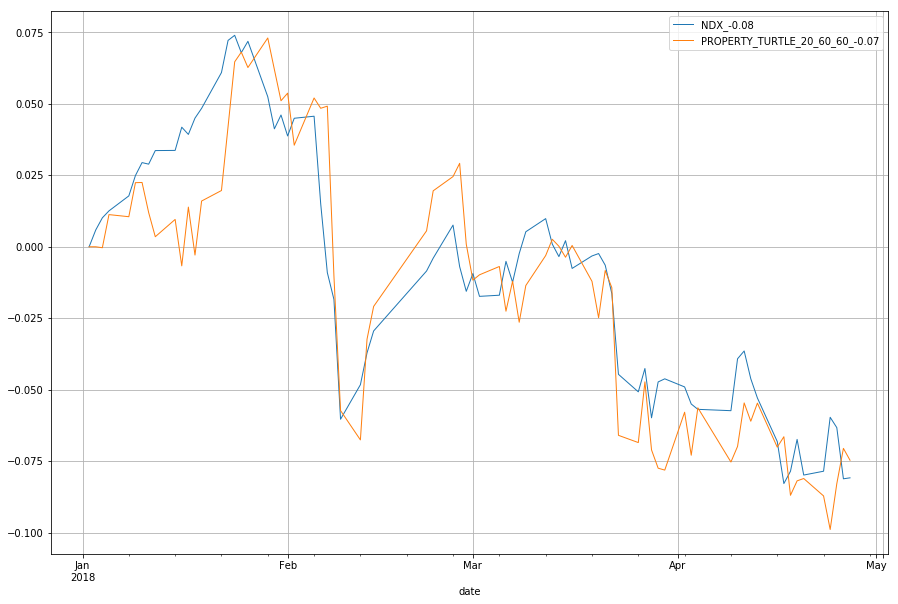

In [14]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

df = show_df.dropna(how='any', inplace=False).copy()
# df.drop(columns=['open', 'high', 'low', 'o_pct_chg', 'TR', 'N'], inplace=True)
df.columns

df['close'] = (df['close'] - df.iloc[0]['close']) / df.iloc[0]['close']
ax = df.plot(kind='line', y='close', label='NDX_%.2f' % df.iloc[-1]['close'], linewidth=1, grid=True)
for col in sorted(df.columns):
    if 'PROPERTY' in col:
        df[col] = (df[col] - df.iloc[1][col]) / df.iloc[0][col]
        ax = df.plot(kind='line', y=col, secondary_y=False, label='%s_%.2f' % (col, df.iloc[-1][col]), linewidth=1, grid=True, ax=ax)

# display_charts(df, kind='line', figsize=(900, 600), logy=False)

In [15]:
df = show_df.dropna(how='any', inplace=False).copy()
# df.drop(columns=['open', 'high', 'low', 'o_pct_chg', 'TR', 'N'], inplace=True)
df.columns

df['close'] = (df['close'] - df.iloc[0]['close']) / df.iloc[0]['close']
for col in sorted(df.columns):
    if 'PROPERTY' in col:
        df[col] = (df[col] - df.iloc[1][col]) / df.iloc[0][col]
    if 'CASH' in col:
        df[col] = df[col] / df.iloc[0][col]

df = df.loc[:, ['close', 'CASH_TURTLE_20_60_60', 'PROPERTY_TURTLE_20_60_60']]
df.reset_index(drop=False, inplace=True)
# df.dtypes
# df.iloc[0].date
# df.iloc[0].date.to_timestamp()
# df.iloc[0].date.to_timestamp().to_datetime64()
df['date'] = df['date'].apply(lambda x: x.to_timestamp().to_datetime64())
# df.iloc[0].date
df.set_index(keys=['date'], inplace=True)
# df

display_charts(df, chart_type='stock', figsize=(900, 600), logy=False)

Index(['open', 'close', 'o_pct_chg', 'ROLLING_20_MAX', 'ROLLING_20_MIN',
       'ROLLING_60_MAX', 'ROLLING_60_MIN', 'MA180', 'MA60', 'MA30',
       'CASH_TURTLE_20_60_60', 'PROPERTY_TURTLE_20_60_60'],
      dtype='object')